# Formation PyTorch : les bases pour être autonome 
#### 19 avril 2023 de 9h à 17h à l'OMP (salle Coriolis)

# Partie 4
## Modélisation probabiliste avec PyTorch

Dans cette dernière partie, nous allons nous initier à la modélisation probabiliste avec PyTorch avec un exemple de régression linéaire bayésienne. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

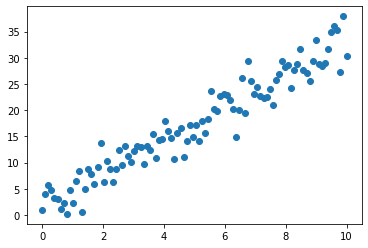

In [3]:
X = torch.linspace(0, 10, 100).unsqueeze(1)
Y = 2.5 + 3*X + 3*torch.randn((100,1))

fig = plt.figure()
plt.scatter(X, Y)
plt.show()

Plutôt que de calculer le maximum de vraisemblance $w^\ast$ des paramètres du modèle linéaire (régression linéaire classique), l'objectif d'une régression linéaire bayésienne est de calculer la distribution des paramètres du modèle linéaire. On modélise la vraisemblance des données $p(y \vert x, w)$ et l'a priori sur les paramètres du modèle $p(w)$ ainsi :

$$p(y \vert x, w) = \mathcal{N}(y \vert x^T w_1 + w_0, \sigma)$$
$$p(w) = \mathcal{N}(w \vert \mu_\circ, \sigma_\circ)$$

Dans le cas présent, on pourrait utiliser la loi de Bayes pour calculer analytiquement la distribution a posteriori $p(w \vert x, y)$. Néanmoins, pour des problèmes non linéaires, il n'y a souvent pas de solutions analytiques. 

Ici, on propose d'implémenter avec PyTorch une approche variationnelle (https://en.wikipedia.org/wiki/Variational_Bayesian_methods) qui consiste à approximer la distribution a posteriori par une distribution $q_\phi(w)$ paramétrée par $\phi$. Dans notre cas, $\phi = [\mu(w_0), \sigma(w_0), \mu(w_1), \sigma(w_1)]$, les moyennes et les écarts-types de l'ordonnée à l'origine et du coefficient directeur.

La fonction objective est une borne supérieure de la log-vraisemblance négative -log $p(x,y)$ : 
$$\mathcal{L}(x,y) = - \mathbb{E}_{q_\phi(w)} \big[\mbox{log} \: p(y \vert x, w)\big] + D_{KL}\big(q_\phi(w) \vert\vert p(w)\big)$$

où $D_{KL}$ désigne la divergence de Kullback-Leibler (https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler), que l'on peut calculer avec PyTorch (https://pytorch.org/docs/stable/distributions.html?highlight=torch+distributions+kl#module-torch.distributions.kl).

Comme la vraisemblance est gaussienne, minimiser le terme - log $p(y \vert x, w)$ revient à minismer l'erreur au carré entre les vrais $y_i$ et les $\hat{y}_i$ prédits. 

Par ailleurs, on approxime l'espérance $\mathbb{E}_{q_\phi(w)}$ avec des échantillons de Monte Carlo comme suit : 
$$ \mathbb{E}_{q_\phi(w)} \big[\mbox{log} \: p(y \vert x, w)\big] \approx \frac{1}{K} \sum_k \mbox{log} \: p(y \vert x, w^k)$$
où $w^k \sim q_\phi(w)$. En pratique, on prend $K=1$.

Ainsi, le modèle linéaire Bayésien est stochastique. Pour efficacement rétro-propager des gradients à travers des couches stochastiques, on va utiliser le "reparametrization trick" introduit dans [1]. Au lieu d'échantillonner $w^k$ à partir de $q_\phi(w)$, on échantillonne un bruit $\epsilon^k$ indépendant de $\phi$:

$$\epsilon^k \sim \mathcal{N}(0,1)$$
$$w^k = \mu(w) + \epsilon^k \cdot \sigma(w)$$

[1] Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.

In [4]:
class BayesianLinearModel(torch.nn.Module):
    def __init__(self, x_dim):
        super(BayesianLinearModel, self).__init__()
        self.x_dim = x_dim
        self.mu = Parameter(torch.randn(2,1), requires_grad=True)
        self.logvar = Parameter(torch.rand(2,1), requires_grad=True)
        
    def IP(self, level=0.95):
        posterior = torch.distributions.normal.Normal(self.mu, torch.exp(self.logvar/2))
        low = posterior.icdf(torch.ones_like(self.mu)*(1-level)/2)
        high = posterior.icdf(torch.ones_like(self.mu)*(level+(1-level)/2))
        return low, high
        
    def forward(self, x):
        mu = self.mu
        std = torch.exp(self.logvar/2)
        normal = torch.distributions.normal.Normal(0, 1)
        w = mu + std*normal.sample()
        out = torch.mm(x, w[0,:].unsqueeze(1)) + w[1,:].unsqueeze(1)
        return out

In [5]:
model = BayesianLinearModel(X.shape[1])
prior = torch.distributions.normal.Normal(torch.zeros(2,1), 4*torch.ones(2,1))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
beta = 1e-3

for epoch in range(20):
    y_pred = model(X)
    mse = F.mse_loss(Y, y_pred)
    posterior = torch.distributions.normal.Normal(model.mu, torch.exp(model.logvar/2))
    kld = torch.distributions.kl.kl_divergence(posterior, prior).sum()
    loss = mse + beta*kld
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f'=== Epoch {epoch} ===  ')
    print(f'MSE: {mse.item():.3f}')

=== Epoch 0 ===  
MSE: 785.501
=== Epoch 1 ===  
MSE: 271.538
=== Epoch 2 ===  
MSE: 25.252
=== Epoch 3 ===  
MSE: 73.371
=== Epoch 4 ===  
MSE: 8.519
=== Epoch 5 ===  
MSE: 27.835
=== Epoch 6 ===  
MSE: 8.010
=== Epoch 7 ===  
MSE: 111.636
=== Epoch 8 ===  
MSE: 33.088
=== Epoch 9 ===  
MSE: 115.769
=== Epoch 10 ===  
MSE: 125.477
=== Epoch 11 ===  
MSE: 19.862
=== Epoch 12 ===  
MSE: 7.352
=== Epoch 13 ===  
MSE: 26.359
=== Epoch 14 ===  
MSE: 9.244
=== Epoch 15 ===  
MSE: 9.447
=== Epoch 16 ===  
MSE: 10.429
=== Epoch 17 ===  
MSE: 8.118
=== Epoch 18 ===  
MSE: 15.788
=== Epoch 19 ===  
MSE: 8.984


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


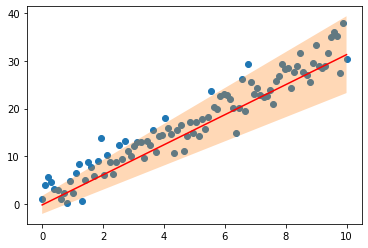

In [7]:
low_w, high_w = model.IP()

with torch.no_grad():
    y_mean = torch.mm(X, model.mu[0,:].unsqueeze(1)) + model.mu[1,:].unsqueeze(1)
    y_low = torch.mm(X, low_w[0,:].unsqueeze(1)) + low_w[1,:].unsqueeze(1)
    y_high = torch.mm(X, high_w[0,:].unsqueeze(1)) + high_w[1,:].unsqueeze(1)
    
fig = plt.figure()
plt.scatter(X, Y)
plt.plot(X, y_mean, color='red')
plt.fill_between(X.view(-1), y_low.view(-1), y_high.view(-1), alpha=0.3)
plt.show()